In [39]:
import os
import random
import copy
import time

import torch 
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage
from PIL import Image, ImageEnhance, ImageOps

from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import functional as F

import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.datasets as datasets

data_dir = 'data'
data_2019_dir = os.path.join(data_dir, 'ISIC_2019')
data_2020_dir = os.path.join(data_dir, 'ISIC_2020')

train_dir_2019 = os.path.join(data_2019_dir, 'train')
train_dir_2020 = os.path.join(data_2020_dir, 'train')

test_dir_2019 = os.path.join(data_2019_dir, 'test')
test_dir_2020 = os.path.join(data_2020_dir, 'test')

train_class_2019 = os.path.join(data_2019_dir, 'train.csv')
train_class_2020 = os.path.join(data_2020_dir, 'train.csv')

test_meta_2019 = os.path.join(data_2019_dir, 'test.csv')
test_meta_2020 = os.path.join(data_2020_dir, 'test_meta.csv')

image_data = {'train':[train_dir_2019, train_dir_2020], 'test':[test_dir_2019, test_dir_2020]}
label_data = {'train':[train_class_2019, train_class_2020], 'test':[test_meta_2019, test_meta_2020]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
df = pd.read_csv(train_class_2019)
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df.count()

image    25331
MEL      25331
NV       25331
BCC      25331
AK       25331
BKL      25331
DF       25331
VASC     25331
SCC      25331
UNK      25331
dtype: int64

In [27]:
class Melanoma(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.skin_labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.skin_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.skin_labels.iloc[idx, 0])
        image = Image.open(img_name + '.jpg')

        if 'train' in self.root_dir:
            label = int(self.skin_labels.iloc[idx, 1])
        else:
            label = 0

        if self.transform:
            image = self.transform(image)

        return image, label
    

In [28]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [33]:
class AutoAugment(object):
    def __init__(self):
        self.policies = [
            ['Invert', 0.1, 7, 'Contrast', 0.2, 6],
            ['Rotate', 0.7, 2, 'TranslateX', 0.3, 9],
            ['Sharpness', 0.8, 1, 'Sharpness', 0.9, 3],
            ['ShearY', 0.5, 8, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.5, 8, 'Equalize', 0.9, 2],
            ['ShearY', 0.2, 7, 'Posterize', 0.3, 7],
            ['Color', 0.4, 3, 'Brightness', 0.6, 7],
            ['Sharpness', 0.3, 9, 'Brightness', 0.7, 9],
            ['Equalize', 0.6, 5, 'Equalize', 0.5, 1],
            ['Contrast', 0.6, 7, 'Sharpness', 0.6, 5],
            ['Color', 0.7, 7, 'TranslateX', 0.5, 8],
            ['Equalize', 0.3, 7, 'AutoContrast', 0.4, 8],
            ['TranslateY', 0.4, 3, 'Sharpness', 0.2, 6],
            ['Brightness', 0.9, 6, 'Color', 0.2, 8],
            ['Solarize', 0.5, 2, 'Invert', 0, 0.3],
            ['Equalize', 0.2, 0, 'AutoContrast', 0.6, 0],
            ['Equalize', 0.2, 8, 'Equalize', 0.6, 4],
            ['Color', 0.9, 9, 'Equalize', 0.6, 6],
            ['AutoContrast', 0.8, 4, 'Solarize', 0.2, 8],
            ['Brightness', 0.1, 3, 'Color', 0.7, 0],
            ['Solarize', 0.4, 5, 'AutoContrast', 0.9, 3],
            ['TranslateY', 0.9, 9, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.9, 2, 'Solarize', 0.8, 3],
            ['Equalize', 0.8, 8, 'Invert', 0.1, 3],
            ['TranslateY', 0.7, 9, 'AutoContrast', 0.9, 1],
        ]

    def __call__(self, img):
        img = apply_policy(img, self.policies[random.randrange(len(self.policies))])
        return img

In [34]:
operations = {
    'ShearX': lambda img, magnitude: shear_x(img, magnitude),
    'ShearY': lambda img, magnitude: shear_y(img, magnitude),
    'TranslateX': lambda img, magnitude: translate_x(img, magnitude),
    'TranslateY': lambda img, magnitude: translate_y(img, magnitude),
    'Rotate': lambda img, magnitude: rotate(img, magnitude),
    'AutoContrast': lambda img, magnitude: auto_contrast(img, magnitude),
    'Invert': lambda img, magnitude: invert(img, magnitude),
    'Equalize': lambda img, magnitude: equalize(img, magnitude),
    'Solarize': lambda img, magnitude: solarize(img, magnitude),
    'Posterize': lambda img, magnitude: posterize(img, magnitude),
    'Contrast': lambda img, magnitude: contrast(img, magnitude),
    'Color': lambda img, magnitude: color(img, magnitude),
    'Brightness': lambda img, magnitude: brightness(img, magnitude),
    'Sharpness': lambda img, magnitude: sharpness(img, magnitude),
    'Cutout': lambda img, magnitude: cutout(img, magnitude),
}

In [36]:
def apply_policy(img, policy):
    if random.random() < policy[1]:
        img = operations[policy[0]](img, policy[2])
    if random.random() < policy[4]:
        img = operations[policy[3]](img, policy[5])

    return img


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = offset_matrix @ matrix @ reset_matrix
    return transform_matrix


def shear_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 0],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img

def shear_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [0, 1, img.shape[1]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img

def rotate(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-30, 30, 11)
    theta = np.deg2rad(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    transform_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img

In [37]:
def auto_contrast(img, magnitude):
    img = ImageOps.autocontrast(img)
    return img


def invert(img, magnitude):
    img = ImageOps.invert(img)
    return img


def equalize(img, magnitude):
    img = ImageOps.equalize(img)
    return img


def solarize(img, magnitude):
    magnitudes = np.linspace(0, 256, 11)
    img = ImageOps.solarize(img, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def posterize(img, magnitude):
    magnitudes = np.linspace(4, 8, 11)
    img = ImageOps.posterize(img, int(round(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))))
    return img


def contrast(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Contrast(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def color(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Color(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def brightness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Brightness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def sharpness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Sharpness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img

In [38]:
def cutout(org_img, magnitude=None):
    img = np.array(img)

    magnitudes = np.linspace(0, 60/331, 11)

    img = np.copy(org_img)
    mask_val = img.mean()

    if magnitude is None:
        mask_size = 16
    else:
        mask_size = int(round(img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])))
    top = np.random.randint(0 - mask_size//2, img.shape[0] - mask_size)
    left = np.random.randint(0 - mask_size//2, img.shape[1] - mask_size)
    bottom = top + mask_size
    right = left + mask_size

    if top < 0:
        top = 0
    if left < 0:
        left = 0

    img[top:bottom, left:right, :].fill(mask_val)

    img = Image.fromarray(img)

    return img



class Cutout(object):
    def __init__(self, length=16):
        self.length = length

    def __call__(self, img):
        img = np.array(img)

        mask_val = img.mean()

        top = np.random.randint(0 - self.length//2, img.shape[0] - self.length)
        left = np.random.randint(0 - self.length//2, img.shape[1] - self.length)
        bottom = top + self.length
        right = left + self.length

        top = 0 if top < 0 else top
        left = 0 if left < 0 else top

        img[top:bottom, left:right, :] = mask_val

        img = Image.fromarray(img)

        return img

In [ ]:
if mdlParams['balance_classes'] < 3 or mdlParams['balance_classes'] == 7 or mdlParams['balance_classes'] == 11:
        class_weights = class_weight.compute_class_weight('balanced',np.unique(np.argmax(mdlParams['labels_array'][mdlParams['trainInd'],:],1)),np.argmax(mdlParams['labels_array'][mdlParams['trainInd'],:],1)) 
        print("Current class weights",class_weights)
        class_weights = class_weights*mdlParams['extra_fac']
        print("Current class weights with extra",class_weights)             
    elif mdlParams['balance_classes'] == 3 or mdlParams['balance_classes'] == 4:
        # Split training set by classes
        not_one_hot = np.argmax(mdlParams['labels_array'],1)
        mdlParams['class_indices'] = []
        for i in range(mdlParams['numClasses']):
            mdlParams['class_indices'].append(np.where(not_one_hot==i)[0])
            # Kick out non-trainind indices
            mdlParams['class_indices'][i] = np.setdiff1d(mdlParams['class_indices'][i],mdlParams['valInd'])
            #print("Class",i,mdlParams['class_indices'][i].shape,np.min(mdlParams['class_indices'][i]),np.max(mdlParams['class_indices'][i]),np.sum(mdlParams['labels_array'][np.int64(mdlParams['class_indices'][i]),:],0))        
    elif mdlParams['balance_classes'] == 5 or mdlParams['balance_classes'] == 6 or mdlParams['balance_classes'] == 13:
        # Other class balancing loss
        class_weights = 1.0/np.mean(mdlParams['labels_array'][mdlParams['trainInd'],:],axis=0)
        print("Current class weights",class_weights)
        if isinstance(mdlParams['extra_fac'], float):
            class_weights = np.power(class_weights,mdlParams['extra_fac'])
        else:
            class_weights = class_weights*mdlParams['extra_fac']
        print("Current class weights with extra",class_weights) 
    elif mdlParams['balance_classes'] == 9:
        # Only use official indicies for calculation
        print("Balance 9")
        indices_ham = mdlParams['trainInd'][mdlParams['trainInd'] < 25331]
        if mdlParams['numClasses'] == 9:
            class_weights_ = 1.0/np.mean(mdlParams['labels_array'][indices_ham,:8],axis=0)
            #print("class before",class_weights_)
            class_weights = np.zeros([mdlParams['numClasses']])
            class_weights[:8] = class_weights_
            class_weights[-1] = np.max(class_weights_)
        else:
            class_weights = 1.0/np.mean(mdlParams['labels_array'][indices_ham,:],axis=0)
        print("Current class weights",class_weights)             
        if isinstance(mdlParams['extra_fac'], float):
            class_weights = np.power(class_weights,mdlParams['extra_fac'])
        else:
            class_weights = class_weights*mdlParams['extra_fac']
        print("Current class weights with extra",class_weights)

In [ ]:
from torchvision.datasets.folder import default_loader

class ISICDataset(data.Dataset):
    def __init__(self, root, csv_file, image_field, target_field,
                 loader=default_loader, transform=None,
                 target_transform=None, add_extension=None,
                 limit=None, random_subset_size=None):
        self.root = root
        self.loader = loader
        self.image_field = image_field
        self.target_field = target_field
        self.transform = transform
        self.target_transform = target_transform
        self.add_extension = add_extension

        self.data = pd.read_csv(csv_file)

        if random_subset_size:
            self.data = self.data.sample(n=random_subset_size)
            self.data = self.data.reset_index()

        if type(limit) == int:
            limit = (0, limit)
        if type(limit) == tuple:
            self.data = self.data[limit[0]:limit[1]]
            self.data = self.data.reset_index()

        classes = list(self.data[self.target_field].unique())
        classes.sort()
        self.class_to_idx = {classes[i]: i for i in range(len(classes))}
        self.classes = classes

        print('Found {} images from {} classes.'.format(len(self.data), len(classes)))
        for class_name, idx in self.class_to_idx.items():
            n_images = dict(self.data[self.target_field].value_counts())
            print("    Class '{}' ({}): {} images.".format(
                class_name, idx, n_images[class_name]))

    def __getitem__(self, index):
        path = os.path.join(self.root,
                            self.data.loc[index, self.image_field])
        if self.add_extension:
            path = path + self.add_extension
        sample = self.loader(path)
        target = self.class_to_idx[self.data.loc[index, self.target_field]]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

In [31]:
train_file = os.path.join(data_dir, 'train.pth')
val_file = os.path.join(data_dir, 'val.pth')

if os.path.isfile(train_file):
    train_dataset = torch.load(train_file)
else:
    dataset = Melanoma(label_data['train'][0], image_data['train'][0], 
                             transform=data_transforms['train'])
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [21331, 4000])
    torch.save(train_dataset, train_file)
    torch.save(val_dataset, val_file)

val_dataset = torch.load(val_file)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

print("Finish Loading Datasets")
print("Number of training images: ", len(train_dataset))
print("Number of testing images: ", len(val_dataset))

Finish Loading Datasets
Number of training images:  21331
Number of testing images:  4000


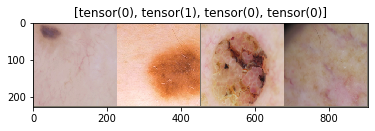

In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x for x in classes])

In [7]:
resnet = models.resnet18(pretrained=True)
n_features = resnet.fc.in_features
resnet.fc = nn.Linear(n_features, 100)
'''model = nn.Sequential(OrderedDict([
          ('ResNet18', resnet),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(100, 2)),
          ('sigmoid', nn.sigmoid())
        ]))'''

model = nn.Sequential(
            resnet,
            nn.ReLU(),
            nn.Linear(100, 2))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
dataloaders = {'train':train_dataloader, 'val':val_dataloader}

In [10]:
import time 
import copy
from barbar import Bar

dataset_sizes = {'train':len(train_dataset), 'val':len(val_dataset)}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in Bar(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = torch.sigmoid(model(inputs))
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            checkpoint = {
                'model': model.state_dict(),
                'accuracy': epoch_acc,
                'epoch': epoch
            }
            torch.save(checkpoint, '%s.pt' % os.path.join('checkpoints', 'checkpoint'))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                checkpoint = {
                    'model': model.state_dict(),
                    'accuracy': best_acc,
                    'epoch': epoch
                }

                print('New optimum found, saving checkpoint now...')
                torch.save(checkpoint, '%s.pt' % os.path.join('checkpoints', 'best_model'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
23126/23126: [===============================>] - ETA 1.4ssss
train Loss: 0.3309 Acc: 0.9824
10000/10000: [===============================>] - ETA 1.5ssss
val Loss: 0.3309 Acc: 0.9824
New optimum found, saving checkpoint now...

Epoch 1/2
----------
23126/23126: [===============================>] - ETA 0.6ssss
train Loss: 0.3309 Acc: 0.9824
 1348/10000: [====>...........................] - ETA 1704.6s

KeyboardInterrupt: 

In [15]:
model.load_state_dict(torch.load('%s.pt' % os.path.join('checkpoints', 'best_model'))['model'])
model.eval()
running_loss = 0.0
running_corrects = 0

for inputs, labels in Bar(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() 

    with torch.set_grad_enabled(False):
        outputs = torch.sigmoid(model(inputs))
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
    if torch.sum(labels.data) > 0:
        print('\n')
        print(preds)
        print(labels.data)
        print('\n')

epoch_loss = running_loss / dataset_sizes[phase]
epoch_acc = running_corrects.double() / dataset_sizes[phase]

   84/10000: [>...............................] - ETA 2358.9s

tensor([0, 0, 0, 0], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')


  132/10000: [>...............................] - ETA 2347.5s

tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')


  164/10000: [>...............................] - ETA 2339.9s

tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 1], device='cuda:0')


  356/10000: [=>..............................] - ETA 2294.2s

tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 1], device='cuda:0')


  396/10000: [=>..............................] - ETA 2284.7s

tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 1], device='cuda:0')




KeyboardInterrupt: 

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
df = pd.read_csv('data/train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [22]:
targets = df.target.to_numpy()
import collections
collections.Counter(targets)

Counter({0: 32542, 1: 584})